## Model Setup

In [1]:
!git clone https://github.com/NathanUA/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1077 (delta 398), reused 380 (delta 380), pack-reused 655 (from 2)
Receiving objects: 100% (1077/1077), 66.95 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (536/536), done.


In [13]:
import os, sys
REPO = "/home/deepaksr/project/Project_files_2/U-2-Net"    
os.chdir(REPO)
sys.path.insert(0, REPO)

## Imports

In [3]:
from model import U2NET, U2NETP

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import pandas as pd

## Data loading

In [5]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        msk = Image.open(self.mask_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
            msk = self.transform(msk)
        return img, msk

In [6]:
def get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16),
    random_state=42
):
    # collect
    img_files, msk_files = [], []
    for d_img, d_msk in zip(image_dirs, mask_dirs):
        imgs = sorted([os.path.join(d_img,f) for f in os.listdir(d_img)
                    if f.lower().endswith(('.jpg','.png'))])
        msks = sorted([os.path.join(d_msk,f) for f in os.listdir(d_msk)
                    if f.lower().endswith(('.jpg','.png'))])
        assert len(imgs)==len(msks), f"Mismatch in {d_img}"
        img_files.extend(imgs); msk_files.extend(msks)

    # splits
    tr, va, te = split_ratio
    train_imgs, tmp_imgs, train_msks, tmp_msks = train_test_split(
        img_files, msk_files, test_size=(1-tr), random_state=random_state)
    val_prop = va/(va+te)
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        tmp_imgs, tmp_msks, test_size=(1-val_prop), random_state=random_state)

    print(f"Total: {len(img_files)} | Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # transforms
    tfm = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    dl = lambda imgs, msks, bs, shuffle: DataLoader(
        SaliencyDataset(imgs, msks, tfm),
        batch_size=bs, shuffle=shuffle
    )

    return (
        dl(train_imgs, train_msks, batch_sizes[0], True),
        dl(val_imgs,   val_msks,   batch_sizes[1], False),
        dl(test_imgs,  test_msks,  batch_sizes[2], False)
    )

## Training Setup

In [7]:
bce_loss = nn.BCELoss()
def multi_bce_loss_fusion(d0,d1,d2,d3,d4,d5,d6,labels):
    losses = [bce_loss(d,labels) for d in (d0,d1,d2,d3,d4,d5,d6)]
    return losses[0], sum(losses)

def train_model(model, train_loader, val_loader,
                optimizer,
                scheduler=None,
                num_epochs=25,
                log_prefix="u2net_finetune",
                device="cuda"):
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./training_logs/{log_prefix}_{ts}"
    os.makedirs(log_dir, exist_ok=True)
    best_loss = float('inf'); best_path=None
    train_losses, val_losses, lrs = [],[],[]

    for epoch in range(num_epochs):
        model.train(); t_loss=0
        for imgs, msks in train_loader:
            imgs,msks = imgs.to(device),msks.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            l0, loss = multi_bce_loss_fusion(*outs, msks)
            loss.backward(); optimizer.step()
            t_loss += loss.item()
        train_losses.append(t_loss/len(train_loader))

        # val
        model.eval(); v_loss=0
        with torch.no_grad():
            for imgs, msks in val_loader:
                imgs,msks = imgs.to(device),msks.to(device)
                outs = model(imgs)
                _, loss = multi_bce_loss_fusion(*outs, msks)
                v_loss += loss.item()
        val_losses.append(v_loss/len(val_loader))

        lr = optimizer.param_groups[0]['lr']; lrs.append(lr)
        if scheduler: scheduler.step(val_losses[-1])
        print(f"[{epoch+1}/{num_epochs}] LR:{lr:.1e} Train:{train_losses[-1]:.4f} Val:{val_losses[-1]:.4f}")

        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            best_path = os.path.join(log_dir,"best_model.pth")
            torch.save(model.state_dict(), best_path)
            print(f"Saved best model: {best_path}")

    # plot & csv
    plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val")
    plt.legend(); plt.title("Loss Curve"); plt.grid(True)
    plt.savefig(os.path.join(log_dir,"loss.png")); plt.show()

    df = pd.DataFrame({
        "epoch": list(range(1,num_epochs+1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "lr": lrs
    })
    df.to_csv(os.path.join(log_dir,"loss_log.csv"),index=False)
    print(f"Logs saved to {log_dir}")
    return best_path


## Evaluation Setup

In [8]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m = masks.numpy()  # (B,1,H,W)
        for slice in m:
            binary = (slice[0] >= bin_thresh).astype(np.uint8)
            frac = binary.sum() / binary.size
            if 0 < frac < min_frac:
                min_frac = frac
    return min_frac if min_frac < float('inf') else 0.0

def evaluate_model(
    model, dataloader, device,
    bin_thresh=0.5, area_frac=0.001,
    compute_area_frac=False, beta2=0.3,
    visualize=False, save_folder=None
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f}")

    mae_sum = prec_sum = rec_sum = 0
    iou_list = []
    y_true = []
    y_pred = []
    n = 0

    # create save folder
    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (imgs, msks) in enumerate(dataloader):
            imgs, msks = imgs.to(device), msks.to(device)
            outs = model(imgs)            # tuple of 7 outputs
            d0 = outs[0]                  # first side-output
            # normalize per-sample
            d0 = (d0 - d0.min()) / (d0.max() - d0.min() + 1e-8)
            preds = d0.cpu().numpy()      # shape (B,1,H,W)
            gts   = msks.cpu().numpy()

            for i in range(preds.shape[0]):
                pred = preds[i,0]
                gt   = gts[i,0]

                # save mask if requested
                if save_folder:
                    import numpy as _np
                    from PIL import Image as _Image
                    mask_img = (_np.clip(pred,0,1) * 255).astype(_np.uint8)
                    fname = os.path.basename(dataloader.dataset.image_paths[batch_idx * dataloader.batch_size + i])
                    _Image.fromarray(mask_img).save(os.path.join(save_folder, fname))

                # MAE
                mae_sum += np.mean(np.abs(pred - gt))

                # Binarize
                pbin = (pred >= bin_thresh).astype(int).ravel()
                gbin = (gt   >= bin_thresh).astype(int).ravel()

                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()

                prec = tp / (tp + fp + 1e-8)
                rec  = tp / (tp + fn + 1e-8)
                prec_sum += prec
                rec_sum  += rec

                iou_list.append(tp / (tp + fp + fn + 1e-8))

                # presence
                has_gt   = (gbin.sum() / gbin.size) > area_frac
                has_pred = (pbin.sum() / pbin.size) > area_frac
                y_true.append(has_gt)
                y_pred.append(has_pred)

                n += 1

    # aggregate
    mae   = mae_sum / n
    prec  = prec_sum / n
    rec   = rec_sum / n
    fbeta = (1 + beta2) * prec * rec / (beta2 * prec + rec + 1e-8)
    miou  = np.mean(iou_list)
    tp_obj = sum(t and p for t, p in zip(y_true, y_pred))
    fn_obj = sum(t and not p for t, p in zip(y_true, y_pred))
    obj_rec = tp_obj / (tp_obj + fn_obj + 1e-8)

    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_rec:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    if visualize:
        # show last batch’s first sample
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        sample_img = imgs[0].cpu().permute(1, 2, 0)
        axs[0].imshow(sample_img);     axs[0].set_title("Image")
        axs[1].imshow(gts[0,0],cmap='gray'); axs[1].set_title("GT Mask")
        axs[2].imshow(preds[0,0],cmap='gray');axs[2].set_title("Pred Mask")
        plt.show()

    return {
        "mae": mae,
        "precision": prec,
        "recall": rec,
        "f_beta": fbeta,
        "miou": miou,
        "obj_recall": obj_rec,
        "bin_thresh": bin_thresh,
        "area_frac": area_frac
    }


## Direct inference on Pre-Trained model

### Load model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "u2netp"   # or "u2net"
ModelClass = U2NETP if model_name=="u2netp" else U2NET

model = ModelClass(3,1).to(device)
pth = f"saved_models/{model_name}/{model_name}.pth"
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()
print(f"Loaded pretrained {model_name} from {pth}")

# summary 
summary(model, input_size=(3,320,320), device=str(device))


/tmp/ipykernel_1200209/303213023.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=device))


Loaded pretrained u2netp from saved_models/u2netp/u2netp.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160,

/home/deepaksr/project/Project_files_2/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


### 1 - Simulated RGB dataset

In [9]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 2751 | Train: 1925, Val: 413, Test: 413

=== Evaluation Results ===
MAE            : 0.0245
Precision      : 0.4018
Recall         : 0.2461
Fβ (β²=0.3): 0.3506
Mean IoU       : 0.2162
Obj Presence R : 0.5638
Binarize thres.: 0.50
Area fraction  : 0.001000


### 2 - Military paper RGB dataset

In [10]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 2100 | Train: 1469, Val: 315, Test: 316

=== Evaluation Results ===
MAE            : 0.1216
Precision      : 0.0848
Recall         : 0.1576
Fβ (β²=0.3): 0.0949
Mean IoU       : 0.0467
Obj Presence R : 0.4715
Binarize thres.: 0.50
Area fraction  : 0.001000


### 3 - RGB military scenario dataset

In [11]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/images"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# specify a folder if you want to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 26315 | Train: 18420, Val: 3947, Test: 3948

=== Evaluation Results ===
MAE            : 0.2331
Precision      : 0.5935
Recall         : 0.2925
Fβ (β²=0.3): 0.4796
Mean IoU       : 0.2441
Obj Presence R : 0.7466
Binarize thres.: 0.50
Area fraction  : 0.001000


###  4 - RGB combined dataset

In [12]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/images",
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB",
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/saliency_masks",
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB",
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

# specify a folder if you want to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5
)

# save metrics to CSV
pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)

Total: 31166 | Train: 21816, Val: 4675, Test: 4675

=== Evaluation Results ===
MAE            : 0.2076
Precision      : 0.5299
Recall         : 0.2796
Fβ (β²=0.3): 0.4392
Mean IoU       : 0.2274
Obj Presence R : 0.7114
Binarize thres.: 0.50
Area fraction  : 0.001000


## Finetune Pre-Trained model and Evaluate

### 1 - Simulated RGB dataset

#### Load model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "u2netp"   # or "u2net"
ModelClass = U2NETP if model_name=="u2netp" else U2NET

model = ModelClass(3,1).to(device)
pth = f"saved_models/{model_name}/{model_name}.pth"
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()
print(f"Loaded pretrained {model_name} from {pth}")

# summary 
summary(model, input_size=(3,320,320), device=str(device))

Loaded pretrained u2netp from saved_models/u2netp/u2netp.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160,

/tmp/ipykernel_1200209/3723771243.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=device))


#### Finetune

Total: 2751 | Train: 1925, Val: 413, Test: 413
[1/20] LR:1.0e-04 Train:9.4877 Val:4.5353
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[2/20] LR:1.0e-04 Train:3.1975 Val:2.2396
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[3/20] LR:1.0e-04 Train:1.5572 Val:1.5434
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[4/20] LR:1.0e-04 Train:1.0409 Val:0.9306
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[5/20] LR:1.0e-04 Train:0.8553 Val:0.7030
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[6/20] LR:1.0e-04 Train:0.6893 Val:0.5912
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[7/20] LR:1.0e-04 Train:0.6345 Val:0.5121
Saved best model: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth
[8/20] LR:1.0e-04 Train:0.5825 Val:0.4620
S

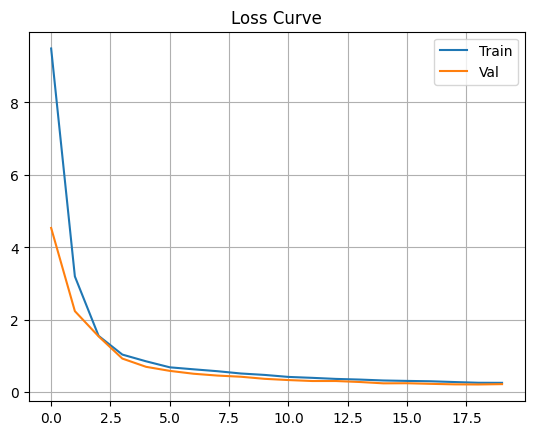

Logs saved to ./training_logs/u2netp_finetune_rgb_d1_20250511_201128
Best checkpoint: ./training_logs/u2netp_finetune_rgb_d1_20250511_201128/best_model.pth


In [14]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_ckpt = train_model(
    model, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_rgb_d1",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [15]:

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0127
Precision      : 0.7045
Recall         : 0.5875
Fβ (β²=0.3): 0.6735
Mean IoU       : 0.5210
Obj Presence R : 0.8457
Binarize thres.: 0.50
Area fraction  : 0.001000


### 2 - Military Paper RGB dataset

#### Load model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "u2netp"   # or "u2net"
ModelClass = U2NETP if model_name=="u2netp" else U2NET

model = ModelClass(3,1).to(device)
pth = f"saved_models/{model_name}/{model_name}.pth"
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()
print(f"Loaded pretrained {model_name} from {pth}")

# summary 
summary(model, input_size=(3,320,320), device=str(device))

Loaded pretrained u2netp from saved_models/u2netp/u2netp.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160,

/tmp/ipykernel_1200209/3723771243.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=device))


#### Finetune

Total: 2100 | Train: 1469, Val: 315, Test: 316
[1/20] LR:1.0e-04 Train:16.7491 Val:13.1150
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[2/20] LR:1.0e-04 Train:9.3755 Val:7.4403
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[3/20] LR:1.0e-04 Train:5.4486 Val:4.5625
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[4/20] LR:1.0e-04 Train:3.3440 Val:3.0269
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[5/20] LR:1.0e-04 Train:2.4085 Val:2.3472
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[6/20] LR:1.0e-04 Train:2.0947 Val:1.9622
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[7/20] LR:1.0e-04 Train:1.8854 Val:1.7639
Saved best model: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth
[8/20] LR:1.0e-04 Train:1.7527 Val:1.6597

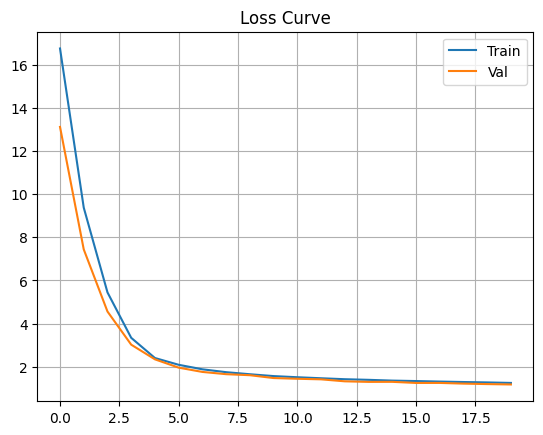

Logs saved to ./training_logs/u2netp_finetune_rgb_d2_20250511_205923
Best checkpoint: ./training_logs/u2netp_finetune_rgb_d2_20250511_205923/best_model.pth


In [17]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_ckpt = train_model(
    model, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_rgb_d2",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [18]:

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.0750
Precision      : 0.4406
Recall         : 0.1319
Fβ (β²=0.3): 0.2861
Mean IoU       : 0.1125
Obj Presence R : 0.6772
Binarize thres.: 0.50
Area fraction  : 0.001000


### 3 - RGB military scenario dataset

#### Load model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "u2netp"   # or "u2net"
ModelClass = U2NETP if model_name=="u2netp" else U2NET

model = ModelClass(3,1).to(device)
pth = f"saved_models/{model_name}/{model_name}.pth"
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()
print(f"Loaded pretrained {model_name} from {pth}")

# summary 
summary(model, input_size=(3,320,320), device=str(device))

Loaded pretrained u2netp from saved_models/u2netp/u2netp.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160,

/tmp/ipykernel_1200209/3723771243.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=device))


#### Finetune

Total: 26315 | Train: 18420, Val: 3947, Test: 3948


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/20] LR:1.0e-04 Train:5.2758 Val:3.1327
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[2/20] LR:1.0e-04 Train:2.9197 Val:2.6530
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[3/20] LR:1.0e-04 Train:2.6076 Val:2.4668
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[4/20] LR:1.0e-04 Train:2.4249 Val:2.3150
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[5/20] LR:1.0e-04 Train:2.2935 Val:2.1996
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[6/20] LR:1.0e-04 Train:2.2022 Val:2.1266
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[7/20] LR:1.0e-04 Train:2.1275 Val:2.0673
Saved best model: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth
[8/20] LR:1.0e-04 Train:2.0614 Val:2.0214
Saved best model: ./training_logs/u2netp_finetun

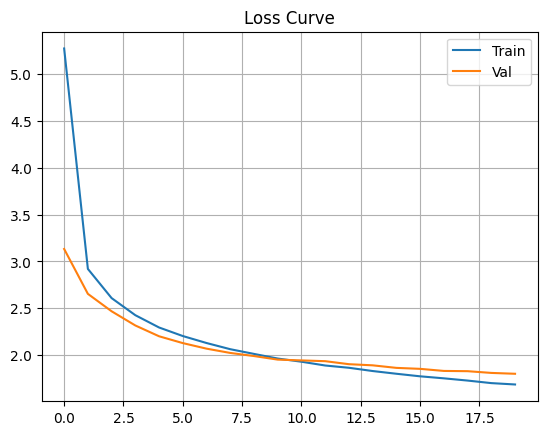

Logs saved to ./training_logs/u2netp_finetune_rgb_d3_20250511_212906
Best checkpoint: ./training_logs/u2netp_finetune_rgb_d3_20250511_212906/best_model.pth


In [20]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/images"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_ckpt = train_model(
    model, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_rgb_d3",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [21]:

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.1446
Precision      : 0.7606
Recall         : 0.7129
Fβ (β²=0.3): 0.7490
Mean IoU       : 0.6030
Obj Presence R : 0.9518
Binarize thres.: 0.50
Area fraction  : 0.001000


###  4 - RGB combined dataset

#### Load model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "u2netp"   # or "u2net"
ModelClass = U2NETP if model_name=="u2netp" else U2NET

model = ModelClass(3,1).to(device)
pth = f"saved_models/{model_name}/{model_name}.pth"
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()
print(f"Loaded pretrained {model_name} from {pth}")

# summary 
summary(model, input_size=(3,320,320), device=str(device))

/tmp/ipykernel_2253403/3723771243.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=device))


Loaded pretrained u2netp from saved_models/u2netp/u2netp.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             ReLU-12         [-1, 16, 160, 160]               0
         REBNCONV-13         [-1, 16, 160,

/home/deepaksr/project/Project_files_2/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


#### Finetune

Total: 31166 | Train: 21816, Val: 4675, Test: 4675


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/20] LR:1.0e-04 Train:4.7038 Val:2.9004
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[2/20] LR:1.0e-04 Train:2.5912 Val:2.4133
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[3/20] LR:1.0e-04 Train:2.3122 Val:2.2081
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[4/20] LR:1.0e-04 Train:2.1490 Val:2.0935
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[5/20] LR:1.0e-04 Train:2.0340 Val:1.9955
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[6/20] LR:1.0e-04 Train:1.9521 Val:1.9407
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[7/20] LR:1.0e-04 Train:1.8896 Val:1.8885
Saved best model: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
[8/20] LR:1.0e-04 Train:1.8

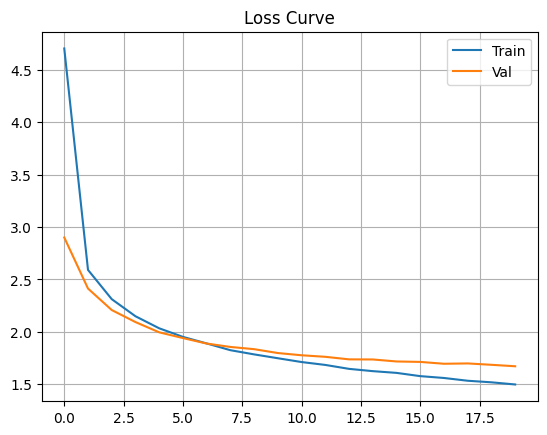

Logs saved to ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546
Best checkpoint: ./training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth


In [9]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/images",
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB",
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/saliency_masks",
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB",
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(16,8,8)
)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_ckpt = train_model(
    model, train_loader, val_loader,
    optimizer,
    scheduler=None,
    num_epochs=20,
    log_prefix="u2netp_finetune_rgb_d4_combined",
    device=device
)

print("Best checkpoint:", best_ckpt)


#### Evaluate

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "u2netp"   # or "u2net"
ModelClass = U2NETP if model_name=="u2netp" else U2NET

model = ModelClass(3,1).to(device)
pth = "/home/deepaksr/project/Project_files_2/U-2-Net/training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth"
model.load_state_dict(torch.load(pth, map_location=device))
model.eval()
print(f"Loaded pretrained {model_name} from {pth}")

# summary 
summary(model, input_size=(3,320,320), device=str(device))

/tmp/ipykernel_2324043/1517450255.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth, map_location=device))


Loaded pretrained u2netp from /home/deepaksr/project/Project_files_2/U-2-Net/training_logs/u2netp_finetune_rgb_d4_combined_20250517_080546/best_model.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
          REBNCONV-4         [-1, 64, 320, 320]               0
            Conv2d-5         [-1, 16, 320, 320]           9,232
       BatchNorm2d-6         [-1, 16, 320, 320]              32
              ReLU-7         [-1, 16, 320, 320]               0
          REBNCONV-8         [-1, 16, 320, 320]               0
         MaxPool2d-9         [-1, 16, 160, 160]               0
           Conv2d-10         [-1, 16, 160, 160]           2,320
      BatchNorm2d-11         [-1, 16, 160, 160]              32
             

/home/deepaksr/project/Project_files_2/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


In [12]:

# folder to dump predicted mask images
#SAVE_PRED_FOLDER = "u2netp_dataset1_direct_predicted_masks"
metrics = evaluate_model(
    model,
    test_loader,
    device=device,
    bin_thresh=0.5,
    compute_area_frac=False,
    beta2=0.3,
    visualize=False,
    save_folder=None
)

# save metrics to CSV
#pd.DataFrame([metrics]).to_csv("u2netp_direct_eval_metrics.csv", index=False)


=== Evaluation Results ===
MAE            : 0.1278
Precision      : 0.7304
Recall         : 0.6675
Fβ (β²=0.3): 0.7148
Mean IoU       : 0.5690
Obj Presence R : 0.9126
Binarize thres.: 0.50
Area fraction  : 0.001000
